##Setup

###imports

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
import copy
import os
from datetime import datetime
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch.autograd import grad

###Mount drive 

**please enter your path to the folder here:**

In [ ]:
your_path = ''  #fill if folder has an inner directorry in your drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive'+your_path

Mounted at /content/gdrive


### parameters

In [ ]:
# parameters
INPUT_SIZE = 32
LATENT_DIM = 62
lrD = 0.0002
lrG = 0.0002
N_CRIT = 5
BETA1 = 0.5
BETA2 = 0.999
LAMBDA = 10
BATCH_SIZE = 64
N_EPOCHS = 50
TRAIN = True
#TRAIN = False

###GPU
Working on gpu is prefered. we will check if gpu is available

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Tensorboard

In [ ]:
# Tensorboard
from tensorflow import summary
%load_ext tensorboard

logs_base_dir = 'logs'
os.makedirs(logs_base_dir, exist_ok=True)

log_dir_dcgan_g_loss = "%s/DCGAN/DCGenerator_loss/%s" % (logs_base_dir,  datetime.now().strftime("%m%d-%H%M"))
log_dir_dcgan_d_loss = "%s/DCGAN/DCDiscriminator_loss/%s" % (logs_base_dir,  datetime.now().strftime("%m%d-%H%M"))

log_dir_wgan_g_loss = "%s/WGAN/WGenerator_loss/%s" % (logs_base_dir,  datetime.now().strftime("%m%d-%H%M"))
log_dir_wgan_d_loss = "%s/WGAN/WDiscriminator_loss/%s" % (logs_base_dir,  datetime.now().strftime("%m%d-%H%M"))

writer_dcgan_g_loss = SummaryWriter(log_dir_dcgan_g_loss)
writer_dcgan_d_loss = SummaryWriter(log_dir_dcgan_d_loss)

writer_wgan_g_loss = SummaryWriter(log_dir_wgan_g_loss)
writer_wgan_d_loss = SummaryWriter(log_dir_wgan_d_loss)

### Load data

In [ ]:
transform = transforms.Compose([transforms.Resize((INPUT_SIZE, INPUT_SIZE)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5), std=(0.5))])

# Download the data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, 
                                 train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, 
                                train=False, transform=transform)
# load the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                          shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, 
                                         shuffle=False, drop_last=True)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## **Architecture**
Now we build our networks

###Generator

In [ ]:
# define generator architecture
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.input_size_q = INPUT_SIZE // 4
    #layers
    self.fc = nn.Sequential(nn.Linear(LATENT_DIM, 1024),
                            nn.BatchNorm1d(1024),
                            nn.ReLU(),
                            nn.Linear(1024, 128 * self.input_size_q**2),
                            nn.BatchNorm1d(128 * self.input_size_q**2),
                            nn.ReLU())
    self.deconv = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, 2, 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.ConvTranspose2d(64, 1, 4, 2, 1),
                                nn.Tanh())
    #init parameters
    for m in self.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        
  def forward(self, x):
    x = self.fc(x)
    x = x.view(-1, 128, self.input_size_q, self.input_size_q)
    x = self.deconv(x)
    return x
  

###discriminator

In [ ]:

# define discriminator architecture
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.input_size_q = INPUT_SIZE // 4
    #layers
    self.conv = nn.Sequential(nn.Conv2d(1, 64, 4, 2, 1),
                              nn.LeakyReLU(0.2),
                              nn.Conv2d(64, 128, 4, 2, 1),
                              nn.BatchNorm2d(128),
                              nn.LeakyReLU(0.2))
    self.fc = nn.Sequential(nn.Linear(128 * self.input_size_q**2, 1024),
                            nn.BatchNorm1d(1024),
                            nn.LeakyReLU(0.2),
                            nn.Linear(1024, 1),
                            nn.Sigmoid())
    #init parameters
    for m in self.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        
  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 128 * self.input_size_q**2)
    x = self.fc(x)
    return x
  

##Train and test functions

###DCGAN trainer

In [ ]:
# train DCGAN
def train_DCGAN(gener, disc, trainloader):
  print('training DCGAN:')
  #put models in device
  gener = gener.to(DEVICE)
  disc = disc.to(DEVICE)
  disc.train()
  gener.train()
  #set target metrices
  y_real = torch.ones(BATCH_SIZE, 1).to(DEVICE)
  y_fake = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
  #set optimizers
  disc_optimizer = optim.Adam(disc.parameters(), lr=lrD)
  gener_optimizer = optim.Adam(gener.parameters(), lr=lrG)
  BCE_loss = nn.BCELoss()

  for e in range(N_EPOCHS):
    for iter , (x, _) in enumerate(trainloader):
      x = x.to(DEVICE)
      #set random latent
      latent = torch.rand((BATCH_SIZE, LATENT_DIM)).to(DEVICE)
      disc_optimizer.zero_grad()
      #get generator images
      g_x = gener(latent)
      #use dicriminator for real and generated images
      d_pred_real = disc(x)
      d_pred_fake = disc(g_x)
      #get discriminator loss
      d_real_loss = BCE_loss(d_pred_real, y_real)
      d_fake_loss = BCE_loss(d_pred_fake, y_fake)
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      disc_optimizer.step()
      #get generator loss
      gener_optimizer.zero_grad()
      g_x = gener(latent)
      d_pred_fake = disc(g_x)
      g_loss = BCE_loss(d_pred_fake, y_real)
      g_loss.backward()
      gener_optimizer.step()
      #print progress 
      if ((iter + 1) % 100) == 0:
        print("Epoch {}/{} : iteration [{}/{}]: Discriminator Loss: {:.5f}, Generator Loss: {:.5f}" \
              .format((e + 1), (N_EPOCHS), (iter + 1),
                      (len(trainloader)),
                      d_loss, g_loss))

      # Tensorboard
      writer_dcgan_g_loss.add_scalar('DCGAN_loss', g_loss.item(), e)
      writer_dcgan_d_loss.add_scalar('DCGAN_loss', d_loss.item(), e)
  
  # Close Tensorboard writers
  writer_dcgan_g_loss.close()
  writer_dcgan_d_loss.close()
  # save models
  torch.save(gener.state_dict(), path+'/DCGAN_Generator.pth')
  torch.save(disc.state_dict(), path+'/DCGAN_discriminator.pth')
  print("End training")


###WGAN trainer

In [ ]:
# train WGAN
def train_WGAN(gener, disc, trainloader):
  print('training WGAN:')
  #put models in device
  gener = gener.to(DEVICE)
  disc = disc.to(DEVICE)
  disc.train()
  gener.train()
  #set target metrices
  y_real = torch.ones(BATCH_SIZE, 1).to(DEVICE)
  y_fake = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
  #set optimizers
  disc_optimizer = optim.Adam(disc.parameters(), lr=lrD, betas=(BETA1, BETA2))
  gener_optimizer = optim.Adam(gener.parameters(), lr=lrG, betas=(BETA1, BETA2))
  BCE_loss = nn.BCELoss()

  for e in range(N_EPOCHS):
    for iter , (x, _) in enumerate(trainloader):
      x = x.to(DEVICE)
      #set random latent
      latent = torch.rand((BATCH_SIZE, LATENT_DIM)).to(DEVICE)
      disc_optimizer.zero_grad()
      #get generator images
      g_x = gener(latent)
      #use dicriminator for real and generated images
      d_pred_real = disc(x)
      d_pred_fake = disc(g_x)
      #get discriminator loss
      d_real_loss = -torch.mean(d_pred_real)
      d_fake_loss = torch.mean(d_pred_fake)
      
      # Performing Gradient panelty 
      alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).to(DEVICE)
      alpha = alpha.expand(x.data.size()).to(DEVICE)
      # Calculate x_hat
      x_hat = alpha * x.data + (1 - alpha) * g_x.data
      x_hat.requires_grad = True
      pred_hat = disc(x_hat)
      gradients = grad(outputs=pred_hat, inputs=x_hat, 
                       grad_outputs=torch.ones(pred_hat.size()).to(DEVICE),
                       create_graph=True, retain_graph=True, 
                       only_inputs=True)[0] 
      gradient_penalty = LAMBDA * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()
      
      # total loss
      d_loss = d_real_loss + d_fake_loss + gradient_penalty
      d_loss.backward()
      disc_optimizer.step()
      
      if ((iter+1) % N_CRIT) == 0:
        # get generator loss
        gener_optimizer.zero_grad()
        g_x = gener(latent)
        d_pred_fake = disc(g_x)
        g_loss = -torch.mean(d_pred_fake)
        g_loss.backward()
        gener_optimizer.step()
        # Tensorboard
        writer_wgan_g_loss.add_scalar('WGAN_loss', g_loss.item(), e)
        writer_wgan_d_loss.add_scalar('WGAN_loss', d_loss.item(), e)     
      #print progress 
      if ((iter + 1) % 100) == 0:
        print("Epoch {}/{} : iteration [{}/{}]: Discriminator Loss: {:.5f}, Generator Loss: {:.5f}" \
              .format((e + 1), (N_EPOCHS), (iter + 1),
                      (len(trainloader)),
                      d_loss, g_loss))


  
  # Close Tensorboard writers
  writer_wgan_g_loss.close()
  writer_wgan_d_loss.close()
  # save models
  torch.save(gener.state_dict(), path+'/WGAN_Generator.pth')
  torch.save(disc.state_dict(), path+'/WGAN_discriminator.pth')
  print("End training")


###test function

In [ ]:
def concat_images(images, window_size):
    # Orgenisze one image that contain several images  
    win_h, win_w = window_size
    im_h         = images.shape[1]
    im_w         =  images.shape[2]
    img      = np.zeros((im_h * win_h, im_w * win_w))
    for idx, image in enumerate(images):
      img[(idx // win_w) * im_h:(idx // win_w) * im_h + im_h, (idx % win_w) * im_w:(idx % win_w) * im_w + im_w] = image[:,:,0]
    return np.squeeze(img)



def test(GAN_type, sample_num=36, latent_dim=LATENT_DIM):
      if GAN_type == 'DC':
        name = '/DCGAN_Generator.pth'
      else:
        name = '/WGAN_Generator.pth'
      generator = Generator()
      generator.load_state_dict(torch.load(path+name))
      generator = generator.to(DEVICE)
      generator.eval()
      # Calculate the image size according to the amount of the images
      window_size = int(np.floor(np.sqrt(sample_num)))

      # Sample random noise
      rand_z   = torch.rand((sample_num, latent_dim)).cuda()
      samples  = generator(rand_z)
      # converting to CPU and numpy
      samples  = (samples.cpu().data.numpy().transpose(0, 2, 3, 1) +1 )/2
      image    = concat_images(samples[:window_size**2, :, :, :], [window_size, window_size])
      # Show results 
      plt.imshow(image, cmap='gray')
      plt.axis('off')
      
      plt.show()


##Train and test

### Train and test DCGAN

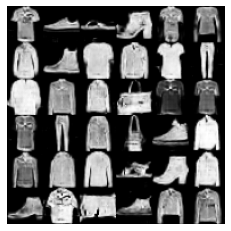

In [ ]:
#train_DCGAN(Generator(), Discriminator(), trainloader)
test('DC')

### Train and test WGAN

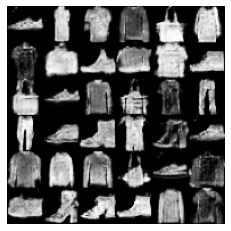

In [ ]:
#train_WGAN(Generator(), Discriminator(), trainloader)
test('W')

###Show training graph

In [ ]:
#tensorboard --logdir {'logs'}

### Real fashion MNIST images

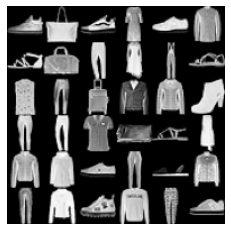

In [ ]:
data, _ = next(iter(trainloader))
data = data[:36, :, :, :]
data = (data.numpy().transpose(0, 2, 3, 1) +1 )/2
image = concat_images(data, [6, 6])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()